In [1]:
import pandas as pd
from pymongo import MongoClient
import re
import numpy as np
import folium
from folium import IFrame
import requests
import os
from Functions.near import findNear
from Functions.employees import sumEmployees
import webbrowser
from dotenv import load_dotenv
load_dotenv()
KEY = os.environ["KEY"]

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client.companies

### Business with 1.000.000 $ raised ###

In [3]:
companies = db.data_companies_clean.find({"total_money_raised":{"$gte": 1000000}})

In [4]:
data_companies = pd.DataFrame(companies)

### List geoDescription

In [5]:
list_geo = []
for e in range(len(data_companies)):
    list_geo.append(data_companies.geoDescription[e]) 

### Function to get near companies

In [6]:
def findNear(list_geo, radio_meters):
        geopoint = list_geo
        return list(db.data_companies_clean.find({
        "geoDescription": {
         "$near": {
             "$geometry": geopoint,
             "$maxDistance": radio_meters
         }
       }
    }
    )
    ) 

radio_meters = 5000
list_number_offices = []
list_offices=[]
for i in range(len(data_companies)):
    num_offices =  findNear(list_geo[i], radio_meters)
    list_offices.append(num_offices)
    list_number_offices.append(len(num_offices))
data_companies['number of offices near'] = list_number_offices

In [7]:
data_companies.head()

,_id,name,category_code,number_of_employees,founded_year,total_money_raised,geoDescription,latitude,longitude,city,country,number of offices near
0,5dd655028accc5aeaf32f6c0,AdaptiveBlue,tech,15.0,2007,24000000,"{'type': 'Point', 'coordinates': [-74.3372, 40...",40.801358,-74.337200,NYC,USA,1
1,5dd655028accc5aeaf32f6c1,Livestream,tech,120.0,2007,14700000,"{'type': 'Point', 'coordinates': [-73.995625, ...",40.726155,-73.995625,New York,USA,42
2,5dd655028accc5aeaf32f6c2,Seesmic,tech,13.0,2007,16000000,"{'type': 'Point', 'coordinates': [-122.419204,...",37.775196,-122.419204,San Francisco,USA,80
3,5dd655028accc5aeaf32f6c5,MeetMoi,social,15.0,2007,5580000,"{'type': 'Point', 'coordinates': [-73.985506, ...",40.757929,-73.985506,New York City,USA,45
4,5dd655028accc5aeaf32f6c7,Scrybe,enterprise,20.0,2007,1310000,"{'type': 'Point', 'coordinates': [-74.761403, ...",40.270666,-74.761403,San Francisco,USA,1


### Rank the business:
#### 1.- Make the mean
#### 2.- Employees per office
#### 3.- Offices near
#### 4.- Make the ranking


In [8]:
data_companies['money by offices'] = data_companies['total_money_raised']/data_companies['number of offices near']

### Sum of employees

In [9]:
data_companies['employee by offices'] = sumEmployees(list_offices)/data_companies['number of offices near']

### Filter just offices near

In [10]:
data_companies = data_companies[data_companies['number of offices near'] > 1]

### Make the ranking

In [11]:
data_companies['Rank_employee'] = data_companies['employee by offices'].rank()
data_companies['Rank_money'] = data_companies['money by offices'].rank()
data_companies['Rank_offices'] = data_companies['number of offices near'].rank()

data_companies.head()

,_id,name,category_code,number_of_employees,founded_year,total_money_raised,geoDescription,latitude,longitude,city,country,number of offices near,money by offices,employee by offices,Rank_employee,Rank_money,Rank_offices
1,5dd655028accc5aeaf32f6c1,Livestream,tech,120.0,2007,14700000,"{'type': 'Point', 'coordinates': [-73.995625, ...",40.726155,-73.995625,New York,USA,42,3.500000e+05,50.000000,206.0,118.5,237.0
2,5dd655028accc5aeaf32f6c2,Seesmic,tech,13.0,2007,16000000,"{'type': 'Point', 'coordinates': [-122.419204,...",37.775196,-122.419204,San Francisco,USA,80,2.000000e+05,52.575000,251.0,80.0,292.0
3,5dd655028accc5aeaf32f6c5,MeetMoi,social,15.0,2007,5580000,"{'type': 'Point', 'coordinates': [-73.985506, ...",40.757929,-73.985506,New York City,USA,45,1.240000e+05,46.711111,187.0,51.0,251.5
5,5dd655028accc5aeaf32f6c8,Wakoopa,tech,8.0,2007,1000000,"{'type': 'Point', 'coordinates': [4.8948623, 5...",52.374523,4.894862,Amsterdam,NLD,6,1.666667e+05,12.000000,19.5,67.5,128.0
6,5dd655028accc5aeaf32f6c9,Dropbox,tech,350.0,2007,257000000,"{'type': 'Point', 'coordinates': [-122.4084994...",37.790943,-122.408499,San Francisco,USA,80,3.212500e+06,52.575000,251.0,272.0,292.0


### Total Ranking Sorted

In [12]:
data_companies['ranking_total'] =  data_companies['Rank_money'] + data_companies['Rank_employee'] + data_companies['Rank_offices']

In [13]:
data_companies = data_companies.sort_values(['ranking_total'], ascending=False)
data_companies.head()

,_id,name,category_code,number_of_employees,founded_year,total_money_raised,geoDescription,latitude,longitude,city,country,number of offices near,money by offices,employee by offices,Rank_employee,Rank_money,Rank_offices,ranking_total
47,5dd655028accc5aeaf32f6fb,Zynga,tech,115.0,2007,860000000,"{'type': 'Point', 'coordinates': [-122.404234,...",37.765158,-122.404234,San Francisco,USA,81,1.061728e+07,52.148148,221.0,315.0,322.0,858.0
370,5dd655028accc5aeaf32f8dd,Sunrun,tech,180.0,2007,337000000,"{'type': 'Point', 'coordinates': [-122.4041075...",37.787131,-122.404107,San Francisco,USA,80,4.212500e+06,52.575000,251.0,285.0,292.0,828.0
6,5dd655028accc5aeaf32f6c9,Dropbox,tech,350.0,2007,257000000,"{'type': 'Point', 'coordinates': [-122.4084994...",37.790943,-122.408499,San Francisco,USA,80,3.212500e+06,52.575000,251.0,272.0,292.0,815.0
216,5dd655028accc5aeaf32f7f6,Groupon,tech,10000.0,2008,114999999999,"{'type': 'Point', 'coordinates': [-87.643622, ...",41.896516,-87.643622,Chicago,USA,9,1.277778e+10,1126.666667,322.5,328.0,151.0,801.5
15,5dd655028accc5aeaf32f6d3,Ooyala,tech,300.0,2007,122000000,"{'type': 'Point', 'coordinates': [-122.084171,...",37.386665,-122.084171,Mountain View,USA,18,6.777778e+06,54.055556,278.5,304.0,215.0,797.5


In [14]:
data_companies = data_companies.reset_index(drop=True)

In [15]:
data_companies.to_csv('./Output/data_companies_selected.csv')

### Connnect to Google Places API

In [16]:
BASE_URL = "https://maps.googleapis.com/maps/api/place/nearbysearch"

### List of schools in San Francisco city close to my favourite Location

In [17]:
res = requests.get("{}/json?location=37.765158, -122.404234&radius=1500&type=school&key={}".format(BASE_URL, KEY)).json()

In [18]:
coordinates_schools_latitude = []
coordinates_schools_longitude = []
name_schools = []
for i in range(len(res['results'])):
    coordinates_schools_latitude.append(res['results'][i]['geometry']['location']["lat"])
    coordinates_schools_longitude.append(res['results'][i]['geometry']['location']["lng"])
    name_schools.append(res['results'][i]['name'])
print(coordinates_schools_latitude, coordinates_schools_longitude, name_schools)

[37.7595222, 37.7662651, 37.7635349, 37.7646348, 37.7664402, 37.7730042, 37.762215, 37.7762375, 37.776527, 37.7745, 37.7676116, 37.7672933, 37.75495340000001, 37.7616204, 37.7720999, 37.7710801, 37.76116409999999, 37.76025120000001, 37.7726402, 37.7605811] [-122.4140747, -122.4020492, -122.3991487, -122.3970541, -122.4189417, -122.4135607, -122.404424, -122.4063687, -122.406369, -122.3988162, -122.4109711, -122.3910103, -122.4151875, -122.403887, -122.4093122, -122.4097826, -122.4112622, -122.3961201, -122.4099154, -122.3958437] ["John O'Connell Technical High School", 'World Gym', 'Live Oak School', 'Emily Coles Dance SF', 'Marshall Elementary School', 'Presidio Knolls School', 'Safety Training Seminars', 'Bessie Carmichael Elementary School', 'Bessie Carmichael Pre K', 'Academy of Art University - School of Fine Art Sculpture', 'Community Alliance-Special Ed', 'Minor Jr Daniel L', 'César Chávez Elementary School', 'Downtown High School', 'The Salvation Army Harbor House', 'Dynamic Dr

### Schools Dataframe

In [19]:
dicc = {'latitude_school':coordinates_schools_latitude,
       'longitude_school': coordinates_schools_longitude,
       'name_school': name_schools}

In [20]:
dataframe_schools = pd.DataFrame(dicc)

In [21]:
display(dataframe_schools)

,latitude_school,longitude_school,name_school
0,37.759522,-122.414075,John O'Connell Technical High School
1,37.766265,-122.402049,World Gym
2,37.763535,-122.399149,Live Oak School
3,37.764635,-122.397054,Emily Coles Dance SF
4,37.766440,-122.418942,Marshall Elementary School
5,37.773004,-122.413561,Presidio Knolls School
6,37.762215,-122.404424,Safety Training Seminars
7,37.776238,-122.406369,Bessie Carmichael Elementary School
8,37.776527,-122.406369,Bessie Carmichael Pre K
9,37.774500,-122.398816,Academy of Art University - School of Fine Art...


In [22]:
data_companies.head()

,_id,name,category_code,number_of_employees,founded_year,total_money_raised,geoDescription,latitude,longitude,city,country,number of offices near,money by offices,employee by offices,Rank_employee,Rank_money,Rank_offices,ranking_total
0,5dd655028accc5aeaf32f6fb,Zynga,tech,115.0,2007,860000000,"{'type': 'Point', 'coordinates': [-122.404234,...",37.765158,-122.404234,San Francisco,USA,81,1.061728e+07,52.148148,221.0,315.0,322.0,858.0
1,5dd655028accc5aeaf32f8dd,Sunrun,tech,180.0,2007,337000000,"{'type': 'Point', 'coordinates': [-122.4041075...",37.787131,-122.404107,San Francisco,USA,80,4.212500e+06,52.575000,251.0,285.0,292.0,828.0
2,5dd655028accc5aeaf32f6c9,Dropbox,tech,350.0,2007,257000000,"{'type': 'Point', 'coordinates': [-122.4084994...",37.790943,-122.408499,San Francisco,USA,80,3.212500e+06,52.575000,251.0,272.0,292.0,815.0
3,5dd655028accc5aeaf32f7f6,Groupon,tech,10000.0,2008,114999999999,"{'type': 'Point', 'coordinates': [-87.643622, ...",41.896516,-87.643622,Chicago,USA,9,1.277778e+10,1126.666667,322.5,328.0,151.0,801.5
4,5dd655028accc5aeaf32f6d3,Ooyala,tech,300.0,2007,122000000,"{'type': 'Point', 'coordinates': [-122.084171,...",37.386665,-122.084171,Mountain View,USA,18,6.777778e+06,54.055556,278.5,304.0,215.0,797.5


### Starbucks close to my location

In [23]:
res = requests.get("{}/json?location=37.765158, -122.404234&radius=1500&type=cafe&key={}&name=Starbucks".format(BASE_URL, KEY))

In [24]:
res = res.json()

### Starbucks dataframe

In [25]:
coordinates_starbucks_latitude = []
coordinates_starbucks_longitude = []
for i in range(len(res['results'])):
    coordinates_starbucks_latitude.append(res['results'][i]['geometry']['location']["lat"])
    coordinates_starbucks_longitude.append(res['results'][i]['geometry']['location']["lng"])
print(coordinates_starbucks_latitude, coordinates_starbucks_longitude)

[37.766884, 37.7658845, 37.767102, 37.771251, 37.7770595, 37.7629128, 37.77867, 37.777035, 37.770242, 37.776819, 37.7711952] [-122.409623, -122.4034908, -122.393893, -122.389289, -122.417347, -122.4104227, -122.396701, -122.393641, -122.403458, -122.394074, -122.3892362]


In [26]:
dicc_starbucks = {'latitude_starbucks':coordinates_starbucks_latitude,
       'longitude_starbucks': coordinates_starbucks_longitude}
dataframe_starbucks = pd.DataFrame(dicc_starbucks)
display(dataframe_starbucks)

,latitude_starbucks,longitude_starbucks
0,37.766884,-122.409623
1,37.765884,-122.403491
2,37.767102,-122.393893
3,37.771251,-122.389289
4,37.777060,-122.417347
5,37.762913,-122.410423
6,37.778670,-122.396701
7,37.777035,-122.393641
8,37.770242,-122.403458
9,37.776819,-122.394074


### Vegan Restaurants Close to my location

In [27]:
res = requests.get("{}/json?location=37.765158, -122.404234&radius=2000&type=restaurant&keyword=vegan&key={}".format(BASE_URL, KEY)).json()

In [28]:
coordinates_vegan_latitude = []
coordinates_vegan_longitude = []
name_vegan = []
for i in range(len(res['results'])):
    coordinates_vegan_latitude.append(res['results'][i]['geometry']['location']["lat"])
    coordinates_vegan_longitude.append(res['results'][i]['geometry']['location']["lng"])
    name_vegan.append(res['results'][i]['name'])
print(coordinates_vegan_latitude, coordinates_vegan_longitude, name_vegan)

[37.7813583, 37.7646261, 37.7778739, 37.76156599999999, 37.781266, 37.7683133, 37.7843069, 37.760768, 37.7834711, 37.771069, 37.7598889, 37.762341, 37.7760097, 37.7548912, 37.7838268] [-122.4167532, -122.4221595, -122.4162916, -122.4190088, -122.4112304, -122.421643, -122.406012, -122.421698, -122.4190544, -122.412835, -122.3882471, -122.4213989, -122.4141668, -122.4228895, -122.4177934] ['Golden Era', 'Indochine Vegan', 'Ananda Fuara', 'Gracias Madre', 'The Flying Falafel', 'Shizen Vegan Sushi Bar and Izakaya', 'Loving Hut', 'Cha-Ya', 'Thai Idea Vegetarian', 'DNA Pizza', 'The Plant Cafe Organic', 'Curry Up Now', 'Moya', 'Tuba Authentic Turkish Restaurant', 'Golden Lotus']


In [29]:
dicc = {'latitude_vegan':coordinates_vegan_latitude,
       'longitude_vegan': coordinates_vegan_longitude,
       'name_vegan': name_vegan}

In [30]:
dataframe_vegan = pd.DataFrame(dicc)

In [31]:
display(dataframe_vegan)

,latitude_vegan,longitude_vegan,name_vegan
0,37.781358,-122.416753,Golden Era
1,37.764626,-122.422160,Indochine Vegan
2,37.777874,-122.416292,Ananda Fuara
3,37.761566,-122.419009,Gracias Madre
4,37.781266,-122.411230,The Flying Falafel
5,37.768313,-122.421643,Shizen Vegan Sushi Bar and Izakaya
6,37.784307,-122.406012,Loving Hut
7,37.760768,-122.421698,Cha-Ya
8,37.783471,-122.419054,Thai Idea Vegetarian
9,37.771069,-122.412835,DNA Pizza


In [32]:
res = requests.get("{}/json?location=37.765158, -122.404234&radius=2000&type=night_club&key={}".format(BASE_URL, KEY)).json()

In [33]:
coordinates_bar_latitude = []
coordinates_bar_longitude = []
name_bar = []
for i in range(len(res['results'])):
    coordinates_bar_latitude.append(res['results'][i]['geometry']['location']["lat"])
    coordinates_bar_longitude.append(res['results'][i]['geometry']['location']["lng"])
    name_bar.append(res['results'][i]['name'])
print(coordinates_bar_latitude, coordinates_bar_longitude, name_bar)

[37.7714589, 37.7710938, 37.7781268, 37.7784685, 37.7790996, 37.7753374, 37.7604849, 37.765222, 37.7816365, 37.7750572, 37.77863379999999, 37.777312, 37.7688759, 37.7592989, 37.771362, 37.7714444, 37.7809871, 37.7686638, 37.7783101, 37.7713746] [-122.4133184, -122.4126502, -122.405787, -122.3943108, -122.3979003, -122.409891, -122.421302, -122.399911, -122.402083, -122.4128419, -122.3933195, -122.403745, -122.4194268, -122.4211814, -122.413792, -122.4137329, -122.4084623, -122.4155052, -122.392598, -122.4143099] ["Slim's", 'DNA Lounge', '1015 Folsom', '25 Lusk', 'The Grand', 'Cat Club', 'The Chapel', 'Thee Parkside', 'Zero Zero', 'AsiaSF', 'District San Francisco', 'The EndUp', 'Public Works', 'Amnesia Beer & Music Hall', 'Audio Nightclub', 'Bergerac', 'Monarch', 'Nihon Whisky Lounge', 'Lucky Strike', 'The Holy Cow']


In [34]:
dicc = {'latitude_bar':coordinates_bar_latitude,
       'longitude_bar': coordinates_bar_longitude,
       'name_bar': name_bar}

In [35]:
dataframe_bar = pd.DataFrame(dicc)

In [36]:
display(dataframe_bar)

,latitude_bar,longitude_bar,name_bar
0,37.771459,-122.413318,Slim's
1,37.771094,-122.412650,DNA Lounge
2,37.778127,-122.405787,1015 Folsom
3,37.778469,-122.394311,25 Lusk
4,37.779100,-122.397900,The Grand
5,37.775337,-122.409891,Cat Club
6,37.760485,-122.421302,The Chapel
7,37.765222,-122.399911,Thee Parkside
8,37.781636,-122.402083,Zero Zero
9,37.775057,-122.412842,AsiaSF


### *FOLIUM MAPS* :

In [37]:
map_sf = folium.Map(location=[37.765158,-122.404234], width=750, height=500, zoom_start=14)
for index, row in data_companies.iterrows():
    folium.Marker([row['latitude'], row['longitude']],
                        radius=7,
                        popup="Name company: {}. Money: {}. Employees{}".format(row['name'], row['total_money_raised'], row['number_of_employees']),
                        icon=folium.Icon(color='red', icon='briefcase')).add_to(map_sf)
for index, row in dataframe_bar.iterrows():
    folium.Marker([row['latitude_bar'], row['longitude_bar']],
                        radius=7,
                        popup="Night Club Name: {}.".format(row['name_bar']),
                        icon=folium.Icon(color='orange', icon='music')).add_to(map_sf)
for index, row in dataframe_schools.iterrows():
    folium.Marker([row['latitude_school'], row['longitude_school']],
                        radius=4,
                        popup="School: {}".format(row['name_school']),
                        icon=folium.Icon(icon='book')                      
                       ).add_to(map_sf)
for index, row in dataframe_vegan.iterrows():
    folium.Marker([row['latitude_vegan'], row['longitude_vegan']],
                        radius=4,
                        popup="Vegan Restaurant: {}".format(row['name_vegan']),
                        icon=folium.Icon(color='darkgreen',icon='leaf')
                       ).add_to(map_sf)
for index, row in dataframe_starbucks.iterrows():
    folium.Marker([row['latitude_starbucks'], row['longitude_starbucks']],
                        radius=4,
                        icon=folium.Icon(color='lightgray',icon='glass'),popup="Starbucks").add_to(map_sf)
folium.Marker([37.765158,-122.404234],
                        radius=4,
                        icon=folium.Icon(color='pink',icon='heart-empty'),
                        popup="FILIPINOS Inc.",).add_to(map_sf)
folium.Circle([37.765158,-122.404234],
                    fill_color='#de2314', color = 'grey', 
                    radius=1500
                   ).add_to(map_sf)



map_sf.save('./Output/map_sf.html')
webbrowser.open('./Output/map_sf.html', new=2)

True

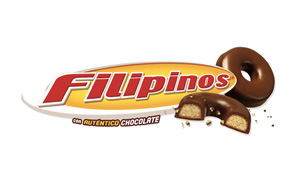
#### 1.- My business <font color=pink>Filipinos Inc is the pink and heart marker</font>
#### 2.-<font color=red>Close Business in Red</font>
#### 3.-<font color=green>Vegan Restaurants in Green</font>
#### 4.-<font color=grey>Starbucks in Grey</font>
#### 5.-<font color=lightblue>Schools are in Blue</font>.
#### 6.-<font color=orange>Night Clubs in Orange</font>.

In [38]:
map_sf